# Estimate the number of book events missing from the dataset.

Book events almost exclusively tracked through the circulation cards, but how many cards survived is unknown and varies dramatically with time. With this in mind can we estimate the total circulation?

Notes
* We will focus exclusively on dates prior to 1942, which leaves out approximately 2 percent
* Only subscription events with solid start and end dates will be used in calculating the book event estimate. This excludes six percent of subscription events.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
MISSING_MEMBERS_ESTIMATE = 0.9856

In [3]:
csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])


In [4]:
book_events = events_df[~events_df.item_uri.isna()].copy()

print(f"Number of surviving book events: {book_events.shape[0]}")
print(f"Number of book events exclusively from logbooks: {book_events[book_events['source_type'] == 'Logbook'].shape[0]}")
print(f"Percent of members have a card: {round(members_df[members_df['has_card']].shape[0] / members_df.shape[0] * 100, 2)}")

# For simplicity, drop empty start dates and events before 1942, which make
#  up a small fraction of the data
book_events['start_date'] = pd.to_datetime(book_events['start_date'], errors='coerce')
book_events = book_events.dropna(subset=['start_date'])
book_events = book_events[book_events['start_date'] < datetime(1942, 1, 1)]

Number of surviving book events: 22479
Number of book events exclusively from logbooks: 23
Percent of members have a card: 11.66


# Get reading habit behavior

Ideally, we'd be able to extrapolate from the borrowing rates of the cards that we have to estimate how many book events we don't have.


### Get Surviving Cards and Membership by Month

In [5]:
subscription_events = events_df[events_df['event_type'].isin(['Subscription', 'Renewal', 'Supplement'])].copy()
subscription_events['start_date_dt'] = pd.to_datetime(subscription_events.start_date, errors='coerce')
subscription_events['end_date_dt'] = pd.to_datetime(subscription_events.end_date, errors='coerce')

# How many null values occur in start or end date?
print(f"Dropping {subscription_events.start_date_dt.isna().sum() + subscription_events.end_date_dt.isna().sum()} subscription events because start or end date is null")
subscription_events = subscription_events.dropna(subset=['start_date_dt', 'end_date_dt'])

# recalculate active members using month range and unique member URIs
# regenerate month range; create a dataframe instead of a list
month_range = pd.DataFrame(data={'month_start': pd.date_range('1919-11-01','1941-12-01', freq='MS')})
# use relative delta to calculate one month — this is the start of the next month and should be considered the outer bound of the range
month_range['month_end'] = month_range.month_start.apply(lambda x: x + relativedelta(months=1))

# annotation subscription events with member info so we can filter on members with cards
subscription_events[['first_member_uri','second_member_uri']] = subscription_events.member_uris.str.split(';', expand=True)
# we only care about uri (for join) and has card
subscription_events_cardinfo = pd.merge(left=subscription_events, right=members_df[["uri", "has_card"]], left_on="first_member_uri", right_on="uri")

def active_membership(d, df_t):
    # find all subscription events that overlap with the month
    # any overlap = subscription starts before month ends AND subscription ends after month starts
    active_subs = df_t[(df_t.start_date_dt < d.month_end) & (df_t.end_date_dt >= d.month_start)]
    # return number of unique member ids
    return len(active_subs.member_uris.unique())

def borrowers_active_membership(d, df_t):
    # same as above, but for members with cards (doesn't account for members active when cards are not extant)
    active_card_subs = df_t[(df_t.start_date_dt < d.month_end) & (df_t.end_date_dt >= d.month_start) & df_t.has_card]
    # return number of unique member ids
    return len(active_card_subs.member_uris.unique())

# generate a new frame with our month ranges and calculate
# - total number of active members/accounts for each month
# - total number of active members/accounts each month for members with a card 
monthly_count_df = month_range.copy()
monthly_count_df['subscriber_count'] = monthly_count_df.apply(active_membership, axis=1, args=(subscription_events,))
monthly_count_df['subscriber_count_with_card'] = monthly_count_df.apply(borrowers_active_membership, axis=1, args=(subscription_events_cardinfo,))

monthly_count_df

Dropping 657 subscription events because start or end date is null


,month_start,month_end,subscriber_count,subscriber_count_with_card
0,1919-11-01,1919-12-01,23,8
1,1919-12-01,1920-01-01,53,15
2,1920-01-01,1920-02-01,72,13
3,1920-02-01,1920-03-01,83,12
4,1920-03-01,1920-04-01,87,14
...,...,...,...,...
261,1941-08-01,1941-09-01,60,21
262,1941-09-01,1941-10-01,67,25
263,1941-10-01,1941-11-01,99,33
264,1941-11-01,1941-12-01,119,40


### Get book events per month

In [6]:
book_event_count_per_month = book_events.groupby([pd.Grouper(key='start_date', freq='M')])['event_type'].count()

# Book events are grouped with the index at the last day of the month, this is a quick workaround
monthly_count_df['month_end'] = monthly_count_df['month_end'] - timedelta(days=1)
monthly_count_df.set_index('month_end', inplace=True)

monthly_count_df['book_event_count'] = book_event_count_per_month

### Calculate Book Event Ratio

count    266.000000
mean       2.987173
std        1.270921
min        0.000000
25%        2.000000
50%        2.835017
75%        3.937500
max        6.847826
Name: book_event_per_member_with_card, dtype: float64


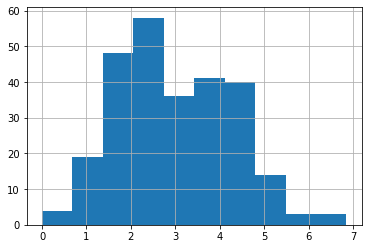

In [7]:
monthly_count_df['book_event_per_member_with_card'] = monthly_count_df['book_event_count'] / monthly_count_df['subscriber_count_with_card']
median_book_events_per_active_member_per_month = monthly_count_df['book_event_per_member_with_card'].median()

print(monthly_count_df['book_event_per_member_with_card'].describe())
monthly_count_df['book_event_per_member_with_card'].hist()

# Apply reading habits to monthly membership


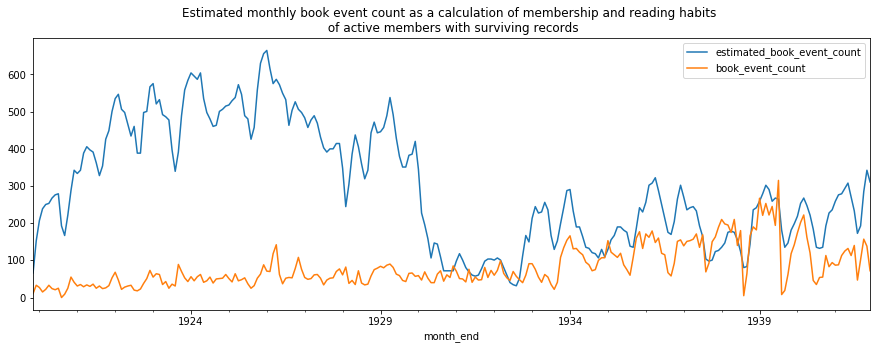

In [8]:
monthly_count_df['estimated_book_event_count'] = monthly_count_df['subscriber_count'] * median_book_events_per_active_member_per_month / MISSING_MEMBERS_ESTIMATE
monthly_count_df[['estimated_book_event_count', 'book_event_count']].plot(figsize=(15, 5), title='Estimated monthly book event count as a calculation of membership and reading habits \n of active members with surviving records')
plt.savefig('output/book-activity-estimates.png')
monthly_count_df.to_csv('output/book-activity-estimates.csv', index=False)

## Results

In [9]:
surviving_book_event_count = monthly_count_df['book_event_count'].sum()
total_book_event_count = monthly_count_df['estimated_book_event_count'].sum() 
percent_surviving_book_events = round(surviving_book_event_count / total_book_event_count * 100, 2)

print(f"Surviving book event count (pre 1942): {surviving_book_event_count}")
print(f"Estimated number of total book events: {int(total_book_event_count)}")
print(f"Estimated proportion of surviving book events: {percent_surviving_book_events}")

Surviving book event count (pre 1942): 21767
Estimated number of total book events: 79608
Estimated proportion of surviving book events: 27.34
